In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)
from matplotlib import style
style.use('ggplot')

df_1 = pd.read_csv('data/heart_rate/series_1', names=['Series 1'], dtype=np.float64)
df_2 = pd.read_csv('data/heart_rate/series_2', names=['Series 2'], dtype=np.float64)

Populating the interactive namespace from numpy and matplotlib


We've just imported two heart rate logs, with the same length.
The measurements (beats per minute) happen in intervals of 0.5 seconds.

In [2]:
timestamps = pd.DataFrame(np.arange(0, len(df_1)/2, 0.5), columns=['Seconds'])
df = pd.concat([timestamps, df_1, df_2], axis=1)
df.head(10)

,Seconds,Series 1,Series 2
0,0.0,84.2697,91.4634
1,0.5,84.2697,91.4634
2,1.0,84.0619,91.1834
3,1.5,85.6542,91.8788
4,2.0,87.2093,91.1772
5,2.5,87.1246,89.7992
6,3.0,86.8726,90.3571
7,3.5,86.7052,92.0227
8,4.0,87.5899,91.9105
9,4.5,89.1475,91.1410


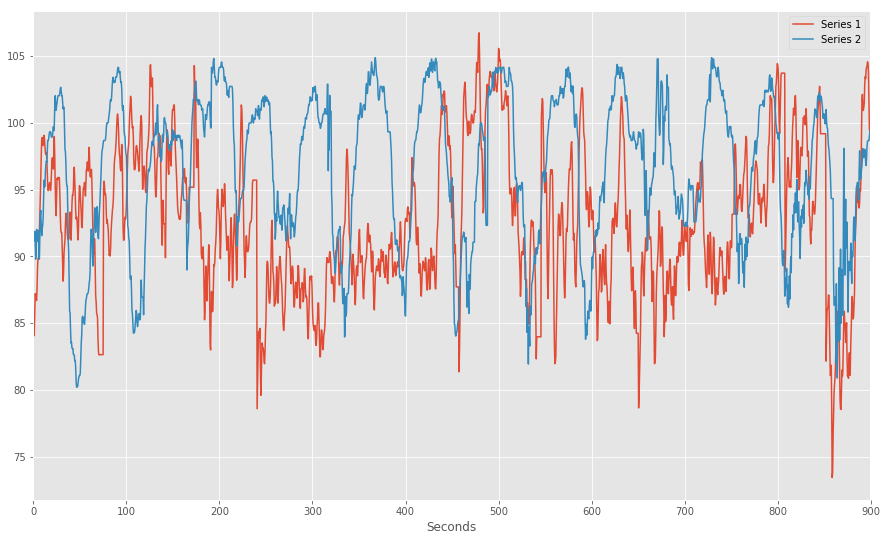

In [3]:
df.plot(x='Seconds', y=['Series 1', 'Series 2'], kind='line', grid=True)

Let's extract some statistics about these logs

In [4]:
pd.concat([df_1, df_2], axis=1).describe()

,Series 1,Series 2
count,1800.000000,1800.000000
mean,92.596114,96.637474
std,5.489339,5.687179
min,73.436600,80.213900
25%,88.847400,92.418925
50%,92.205400,98.238450
75%,96.399025,101.362750
max,106.756000,104.895000


These statistics don't seem to reflect that much the observed shape of these signals...

Would a frequency-domain representation here help?

Let's compute the power spectrum through the periodogram approach

('Frequency with the highest amount of power:', 0.0033333333333333331)
('Frequency with the highest amount of power:', 0.014444444444444444)


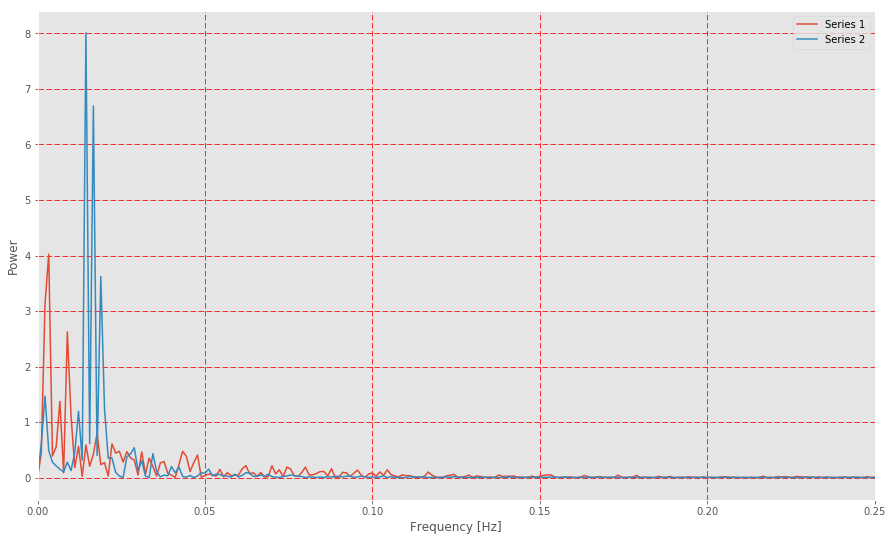

In [5]:
from scipy import signal

fs = 2 # Hertz
scaling_to_use = 'spectrum'

x_limits = [0, fs/8.]
x_label = 'Frequency [Hz]'
y_label = 'Power'

for heart_log in ['Series 1', 'Series 2']:
    f, Pxx_den = signal.periodogram(df[heart_log], fs, scaling=scaling_to_use)
    plt.xlim(x_limits)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, color='r', linestyle='--')
    plt.plot(f, Pxx_den, label=heart_log)
    print("Frequency with the highest amount of power:", f[np.array([Pxx_den]).argmax()])
plt.legend()
    

Now let's try the Welch approach

('Frequency with the highest amount of power:', 0.0088888888888888889)
('Frequency with the highest amount of power:', 0.015555555555555555)


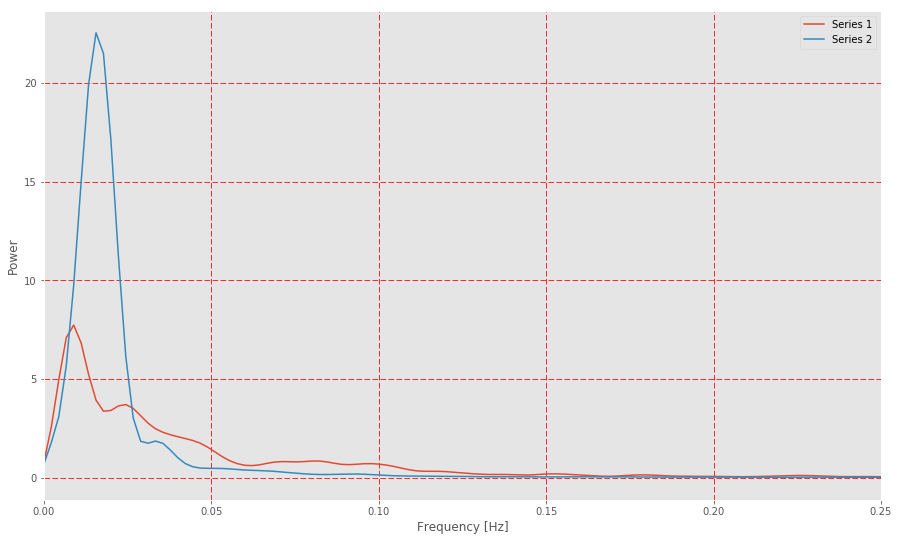

In [6]:
for heart_log in ['Series 1', 'Series 2']:
    f, Pxx_den = signal.welch(df[heart_log], fs, nfft=len(df[heart_log])/2, scaling=scaling_to_use)
    plt.xlim(x_limits)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, color='r', linestyle='--')
    plt.plot(f, Pxx_den, label=heart_log)
    print("Frequency with the highest amount of power:", f[np.array([Pxx_den]).argmax()])
plt.legend()

What about a spectrogram of both of these signals?
This is a time-frequency representation of these signals

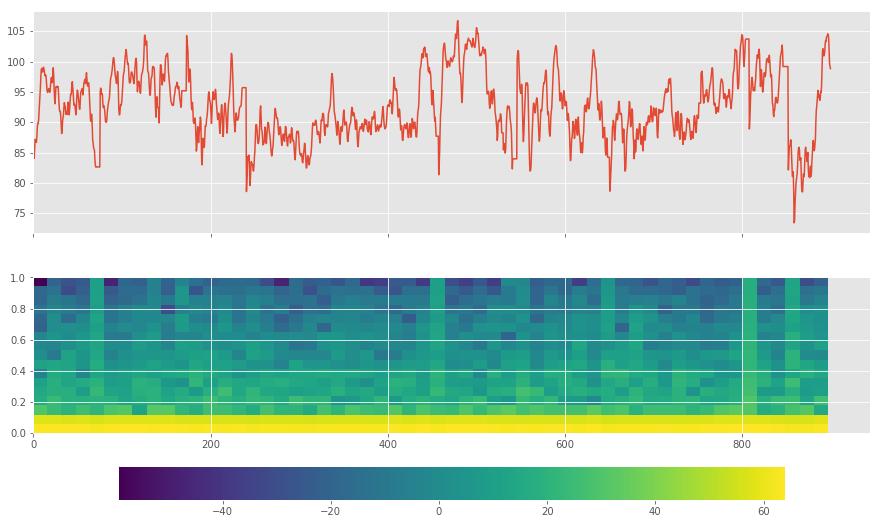

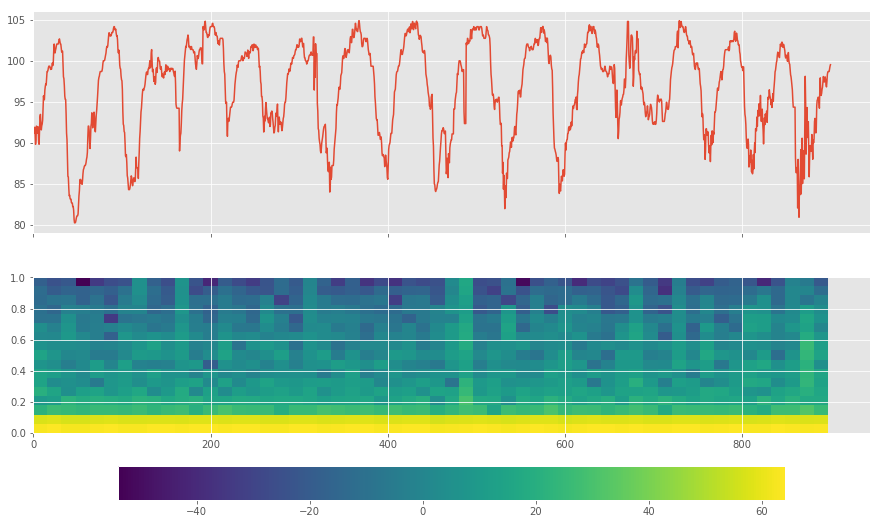

In [7]:
fft_length = 32

for heart_log in ['Series 1', 'Series 2']:
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(df['Seconds'], df[heart_log])
    Pxx, freqs, bins, im = axarr[1].specgram(df[heart_log], NFFT=fft_length, Fs=fs, noverlap=0, mode='magnitude')
    f.colorbar(im, orientation='horizontal')

Very saturated representations in the very low frequencies, how could we make these plots clearer?

We could apply a low-pass filter to remove the DC component, but subtracting the mean from the signal is faster and cheaper. 

We can perform this operation by specifying an additional parameter (detrend='linear') in the specgram function.

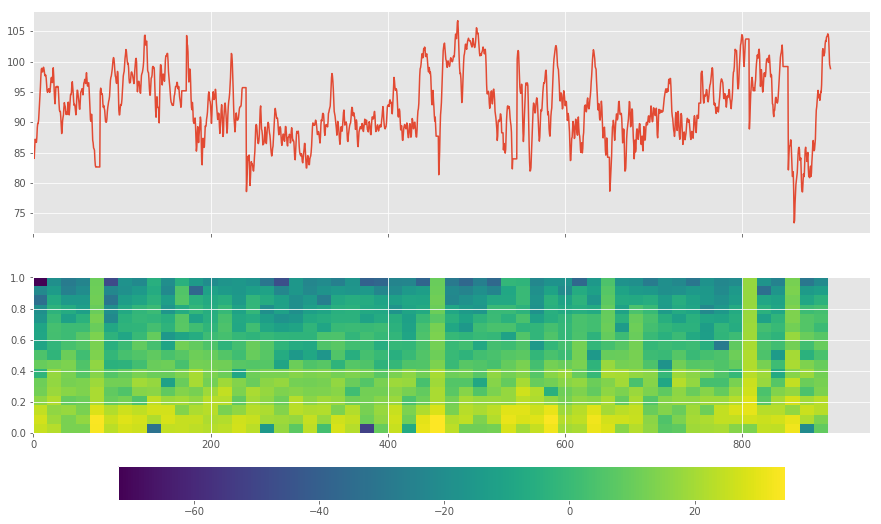

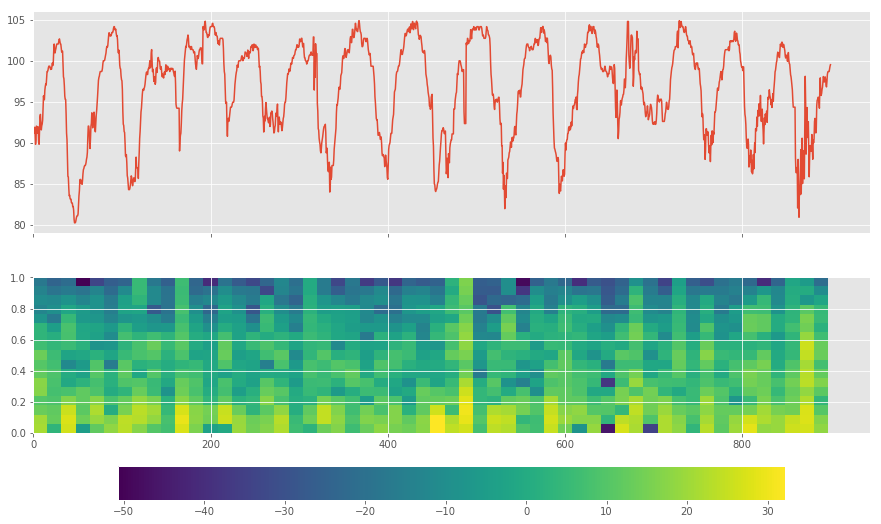

In [8]:
for heart_log in ['Series 1', 'Series 2']:
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(df['Seconds'], df[heart_log])
    Pxx, freqs, bins, im = axarr[1].specgram(df[heart_log], NFFT=fft_length, Fs=fs, noverlap=0, detrend='linear', mode='magnitude')
    f.colorbar(im, orientation='horizontal')

Let's apply a bandpass filter on Series 2. More precisely, a 3rd order Chebyshev of type I

We previously saw that the power spectrum of this signal peaked around 0.015 Hz. 

Let's set the lower and higher cut frequencies of the bandpass filter to 0.01 and 0.02 Hz

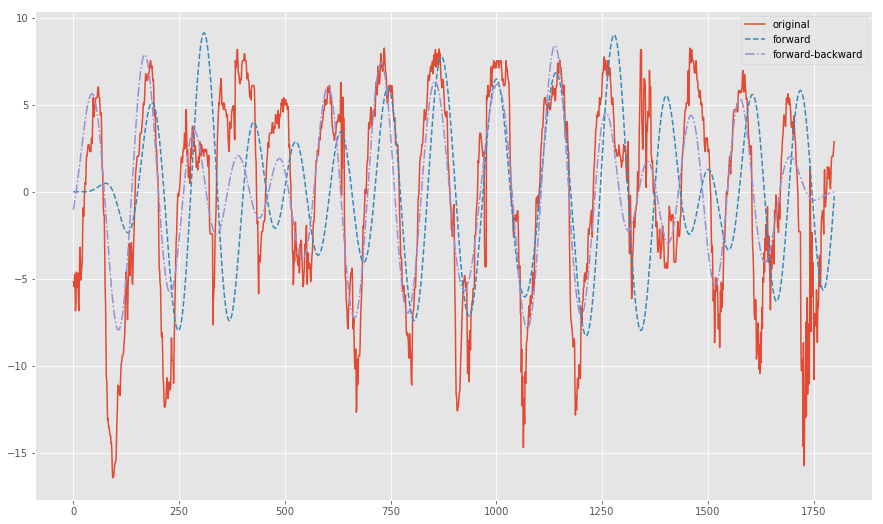

In [9]:
wn_l = 0.01/(0.5*fs)
wn_h = 0.02/(0.5*fs)

b, a = signal.iirfilter(3, [wn_l, wn_h], rp=2, btype='band', analog=False, ftype='cheby1')
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, df['Series 2'], zi=zi*df['Series 2'].iloc[0])
y = signal.filtfilt(b, a, df['Series 2'])

plt.plot(df['Series 2']-df['Series 2'].mean(), label='original')
plt.plot(z, '--', label='forward')
plt.plot(y, '-.', label='forward-backward')
plt.legend()


That's all for now!